In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import fsolve
import gdstk

import tidy3d as td
import tidy3d.web as web

from tidy3d.plugins.mode import ModeSolver

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 100)  # simulation wavelength range
freqs = td.C_0 / ldas  # simulation wavelength range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # frequency width of 

In [3]:
t = 0.21  # thickness of the waveguide
w = 0.4  # width of the waveguide
inf_eff = 100  # effective infinity of the simulation
buffer = 1  # buffer distance



n_si = 3.476  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.444  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)

air = td.Medium(permittivity=1**2)


In [4]:
def bendWvg(width = 0.5,height = 0.22,R = 10,
            linear = 1, offset = 2
            ):
    theta = np.linspace(-np.pi/2,0)
    x = R*np.cos(theta) + linear
    y = R*np.sin(theta) + R + offset

    x = np.append([-linear],x)
    y = np.append([y[0]],y)

    x = np.append(x,x[-1])
    y = np.append(y,y[-1] + linear)

    cell = gdstk.Cell("bend") # define a gds cell
    cell.add(gdstk.FlexPath(x + 1j * y, width, layer=1, datatype=0)) 

    # define structure from cell
    bend = td.PolySlab.from_gds(
            cell,
            gds_layer=1,
            axis=2,
            slab_bounds=(-height/2, height/2),
        )[0]
    return bend,x,y


In [5]:
def set_simulation(R):
    bend,x,y = bendWvg(width=width,height=height,R = R,
                   linear = 2,
                   offset = 2)
    
    structures = [td.Structure(geometry=bend,
                               medium = si)]

    px1 = -1
    px2 = R + width + 4
    sx = px2 - px1
    cx = -1 + sx/2

    py1 = 0
    py2 = 2 + R + 1
    sy = py2 - py1
    cy = py1 + sy/2

    sz = 2 + height
    cz = 0

    size = (sx,sy,sz)
    center = (cx,cy,cz)
    
    mode_spec = td.ModeSpec(num_modes=1,target_neff=3.5)

    source = td.ModeSource(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        center=[px1 + 1,y[0],0],
        size=(0, 4, 2),
        direction="+",
        mode_spec = mode_spec)

    boundary_spec = td.BoundarySpec(
        x=td.Boundary(minus=td.PML(), plus=td.PML()),
        y=td.Boundary(minus=td.PML(), plus=td.PML()),
        z=td.Boundary(minus=td.PML(), plus=td.PML()),
    )

    fieldMon = td.FieldMonitor(center = (0,0,0),
                            size = (td.inf,td.inf,0),
                            freqs = [freq0],
                            name = 'fieldMon')
    
    modeMon = td.ModeMonitor(center = (x[-1],py2-1,0),
                             size = (4,0,2),
                             name = 'modeMon',
                             freqs = [freq0],
                             mode_spec = mode_spec)
    

    grid_spec = td.GridSpec.auto(
        min_steps_per_wvl=15)

    sim =  td.Simulation(
        size=size,
        center=center,
        grid_spec=grid_spec,
        structures=structures,
        sources=[source],
        monitors=[fieldMon,modeMon],
        run_time=1e-12,
        boundary_spec=boundary_spec,
        symmetry = [0,0,1]
    )

    return sim


In [6]:
width=0.5
height=0.22
freq0 = td.C_0/1.5
fwidth = 0.1*freq0
R = 2

sim = set_simulation(R)

<Axes: title={'center': 'cross section at x=0.00'}, xlabel='y', ylabel='z'>

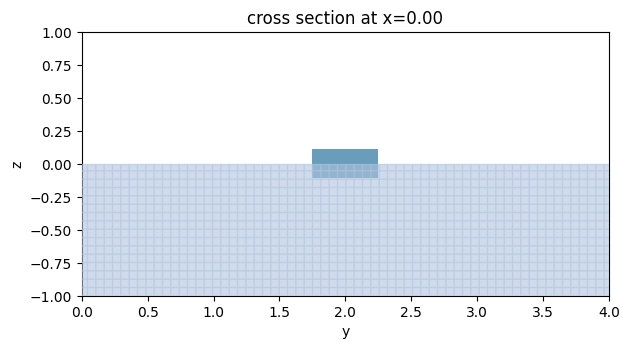

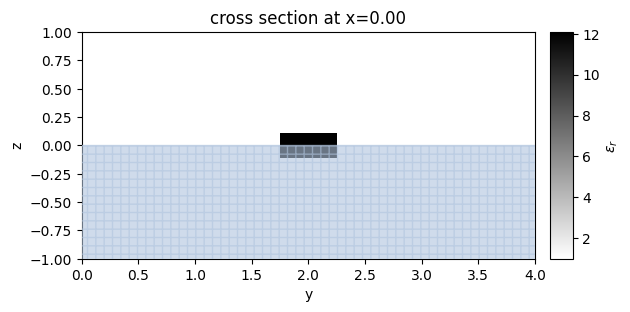

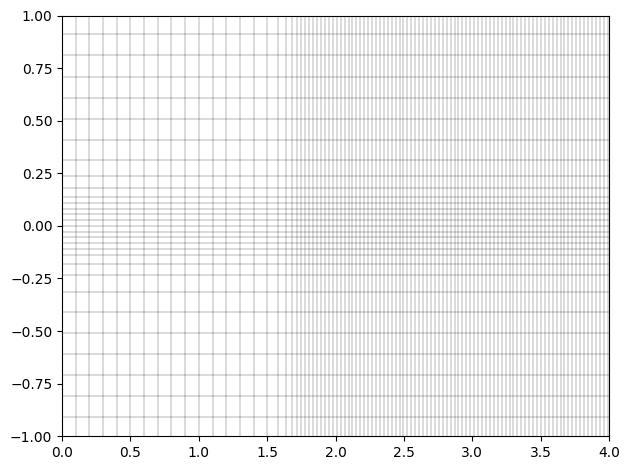

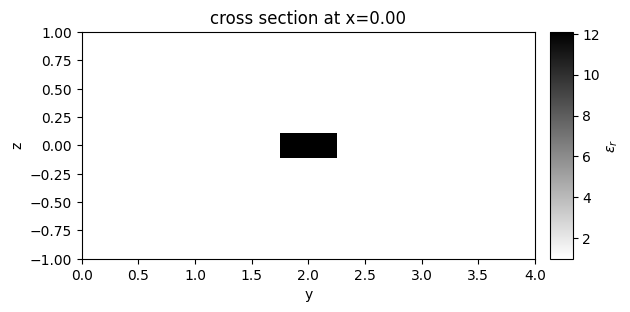

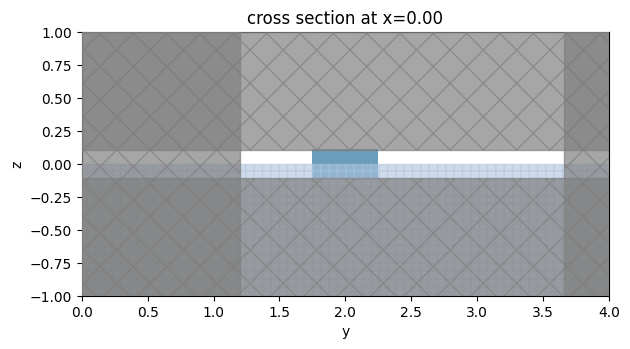

In [7]:
plane = sim.sources[0].geometry


mode_spec=td.ModeSpec(
        num_modes=1,
        bend_radius=None,
        bend_axis=1,
        num_pml=(12, 12),
        target_neff = n_si
    )

ms = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freq0,
)
ms.plot()
ms.plot_eps()
ms.plot_grid()
ms.plot_structures_eps()
ms.plot_pml()

<Axes: title={'center': 'cross section at x=0.00'}, xlabel='y', ylabel='z'>

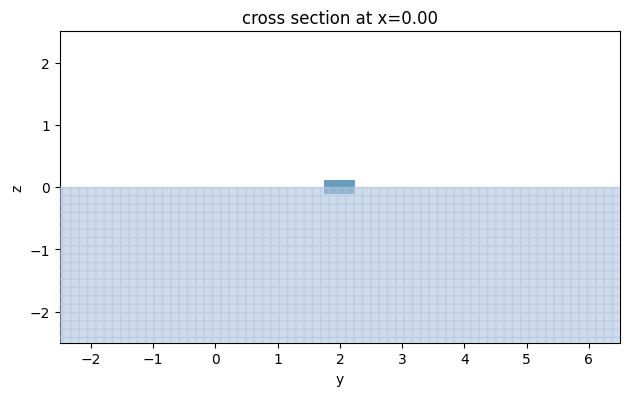

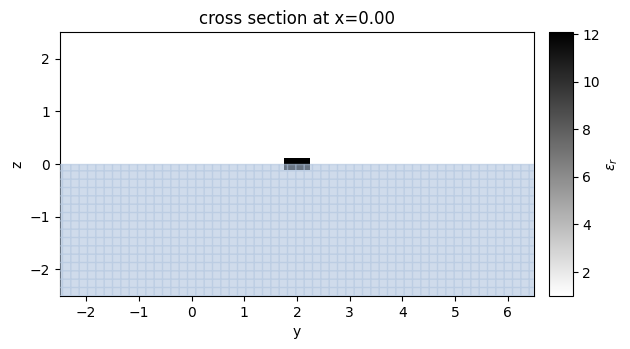

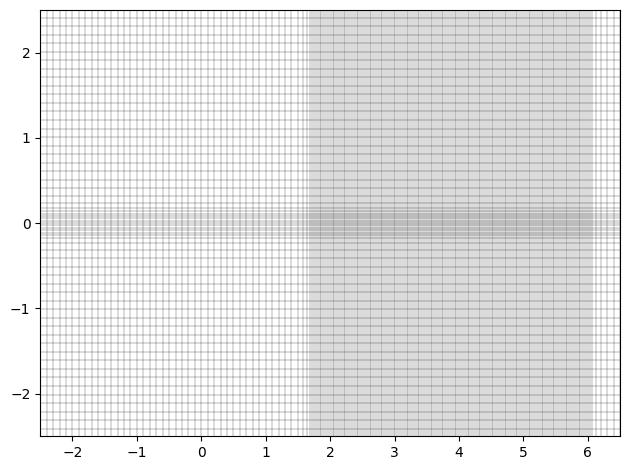

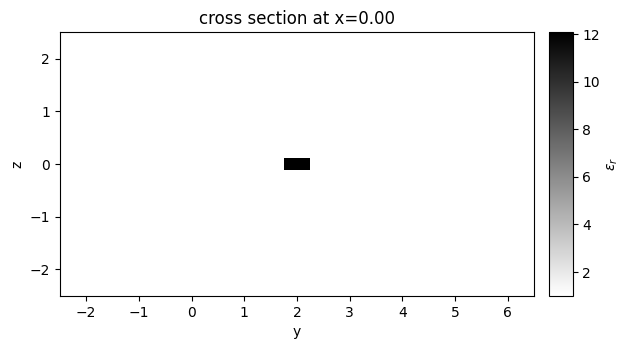

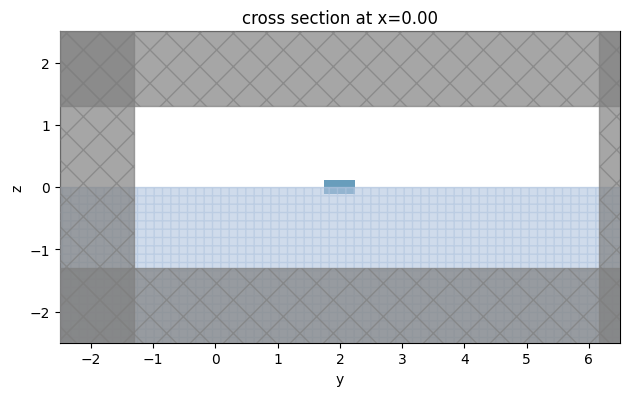

In [8]:
plane = sim.sources[0].geometry
plane = td.Box(center = plane.center,
                size = (0,9,5))


mode_spec=td.ModeSpec(
        num_modes=1,
        bend_radius=None,
        bend_axis=1,
        num_pml=(12, 12),
        target_neff = n_si
    )

ms = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freq0,
)
ms.plot()
ms.plot_eps()
ms.plot_grid()
ms.plot_structures_eps()
ms.plot_pml()

<Axes: title={'center': 'cross section at x=0.00'}, xlabel='y', ylabel='z'>

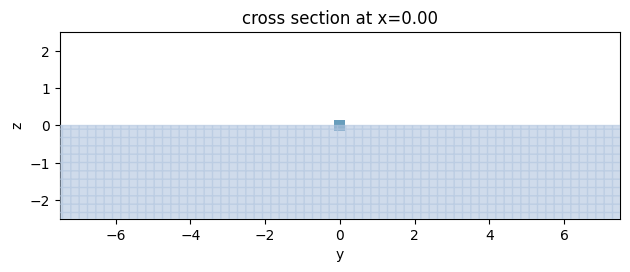

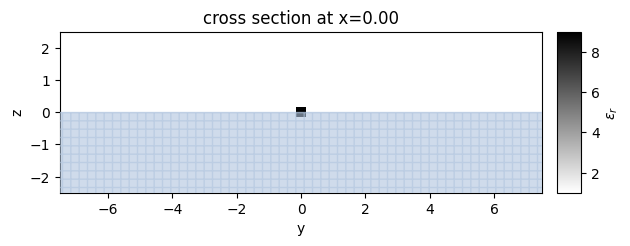

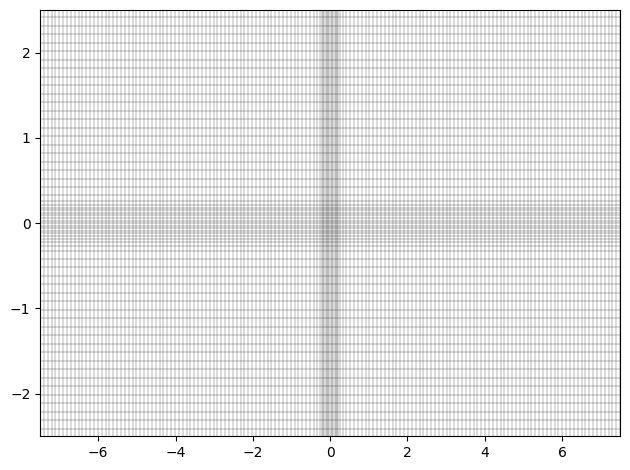

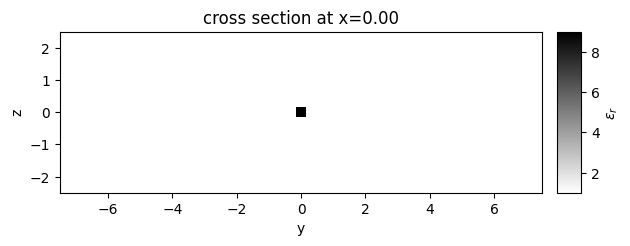

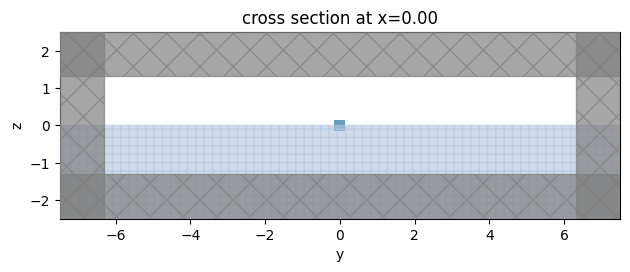

In [9]:
struct = td.Box(size = (999,0.3,0.3),
                center = (0,0,0))

struct = td.Structure(geometry = struct,medium=td.Medium(permittivity=9))

sim2 = sim.updated_copy(structures = [struct],
                        center = (0,0,0),
                        monitors = [])
plane2 = td.Box(center = (0,0,0),
                size = (0,15,5))
                
ms2 = ModeSolver(
    simulation=sim2,
    plane=plane2,
    mode_spec=mode_spec,
    freqs=freq0,
)

ms2.plot()
ms2.plot_eps()
ms2.plot_grid()
ms2.plot_structures_eps()
ms2.plot_pml()